In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import (fu, nu, read_excel, re, nan, DataFrame, concat)


# Whisker Plot for Hemorrhage Control for all Life-threatening Bleeding (HC_completed = 1)

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='',
    first_responder_master_registry_scene_stats_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 367627 290 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 290 290 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 420 290 48

triage_paper_df 367627 290 111
file_stats_df 290 290 19
scene_stats_df 420 290 48


In [4]:

# Merge only count swaps scenes
needed_columns = fu.patient_groupby_columns + [
    'patient_salt', 'action_tick', 'responder_category', 'tag_applied_type'
]
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df,
    file_stats_df,
    scene_stats_df,
    needed_columns=needed_columns,
    patient_count_filter_fn=None
)

# Check if required columns are present
needed_set = set(needed_columns)
all_set = set(elevens_df.columns)
assert needed_set.issubset(all_set), f"elevens_df is missing these columns: {needed_set.difference(all_set)}"

In [5]:

temporalize_fn = lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes')
def show_whisker_plot(
    y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, print_responder_counts=False, verbose=False
):
    df = get_plot_dataframe(y_column_name, scene_fn, logs_df=logs_df, verbose=verbose)
    x_column_name = 'responder_category'
    x_label = ' '.join([w.title() for w in x_column_name.split('_')])

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Create a box plot under the scatter plot; put a black square for the mean instead
    ax = sns.boxplot(
        ax=ax,
        data=df,
        fliersize=0.0,
        meanprops={'marker': 's', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 8},
        showmeans=True,
        x=x_column_name,
        y=y_column_name,
    )

    # Jitter amount
    jitter_amt = 0.1  # Adjust this value to control jitter range

    # Add jittered points
    sns.stripplot(
        alpha=0.25,  # Adjust transparency
        ax=ax,
        color='black',
        data=df,
        jitter=jitter_amt,  # Add jitter
        s=6,  # Adjust marker size
        x=x_column_name,
        y=y_column_name,
    )
    
    adjust_plot(ax, x_label, y_label, FILTERED_CATEGORIES_LIST, ytick_fn)
    plt.show()

    return fig, ax

In [6]:

file_path = '../data/xlsx/swaps_walk_wave_anova_df_May30.xlsx'
swaps_walk_wave_anova_df_May30_df = read_excel(file_path)

In [7]:

# Reproduce the plot but only including those that have HC_completed = 1
import seaborn as sns
from datetime import timedelta

y_column_name = 'time_to_last_hemorrhage_controlled'
y_label = 'Hemorrhage Control for all Life-threatening Bleeding (HC_completed = 1)'
scene_fn = lambda scene_df: fu.get_time_to_last_hemorrhage_controlled(scene_df)
hc_completed_df = DataFrame([], columns=elevens_df.columns)
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (swaps_walk_wave_anova_df_May30_df[cn] == eval(cn))
    if mask_series.any():
        if fu.get_percent_hemorrhage_controlled(scene_df) == 100:
            hc_completed_df = concat([hc_completed_df, scene_df], axis='index')
mask_series = ~hc_completed_df.responder_category.isnull()
CATEGORY_DICT = {'Paramedic': 'EMT-Paramedic', 'EMT-Basic': 'EMT-Basic', 'EM Resident': 'EM-Resident', 'Medical Student': 'Medical Student'}

In [8]:

FILTERED_CATEGORIES_LIST = ['Paramedic', 'EMT-Basic', 'EM Resident', 'Medical Student']
def get_plot_dataframe(
    y_column_name, scene_fn, logs_df=elevens_df, x_column_name='responder_category',
    responder_categories_list=FILTERED_CATEGORIES_LIST, verbose=False
):
    '''
    The order and labeling should be (from left to right):
        EMT-Paramedic
        EMT-Basic
        EM-Resident
        Medical Student
    '''
    rows_list = []
    for responder_category in responder_categories_list:
        if verbose: print('responder_category:', responder_category)
        mask_series = (logs_df[x_column_name] == responder_category)
        responder_categories_df = logs_df[mask_series]
        gb = responder_categories_df.groupby(fu.scene_groupby_columns)
        for (session_uuid, scene_id), scene_df in gb:
            row_dict = {}
            if 'session_uuid' in scene_df.columns: row_dict['session_uuid'] = session_uuid
            if 'scene_id' in scene_df.columns: row_dict['scene_id'] = scene_id
            row_dict[x_column_name] = responder_category
            row_dict[y_column_name] = scene_fn(scene_df)
            row_dict['scene_count'] = gb.size().shape[0]
            rows_list.append(row_dict)
    df = DataFrame(rows_list)
    
    return df

In [9]:

def adjust_plot(ax, x_label, y_label, responder_categories_list, ytick_fn=temporalize_fn):
    
    # Set the grid and labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.grid(False)
    
    # Humanize y tick labels
    locs, labels = plt.yticks()
    yticklabels_list = []
    for ytick_value, text_obj in zip(locs, labels):
        text_obj.set_text(ytick_fn(ytick_value))
        yticklabels_list.append(text_obj)
    plt.yticks(locs[1:], yticklabels_list[1:])

    # Re-label x tick labels
    locs, labels = plt.xticks()
    xticklabels_list = []
    for idx, text_obj in zip(locs, labels):
        text_obj.set_text(CATEGORY_DICT[responder_categories_list[idx]])
        xticklabels_list.append(text_obj)
    plt.xticks(locs, xticklabels_list)
    
    # Rotate the x-axis tick labels to prevent overlapping
    plt.xticks(rotation=45)

    # Start the scale at 0 to be consistent with the other graphs
    ylim_tuple = ax.get_ylim()
    ylim_tuple = (0, ylim_tuple[1])
    ax.set_ylim(ylim_tuple)

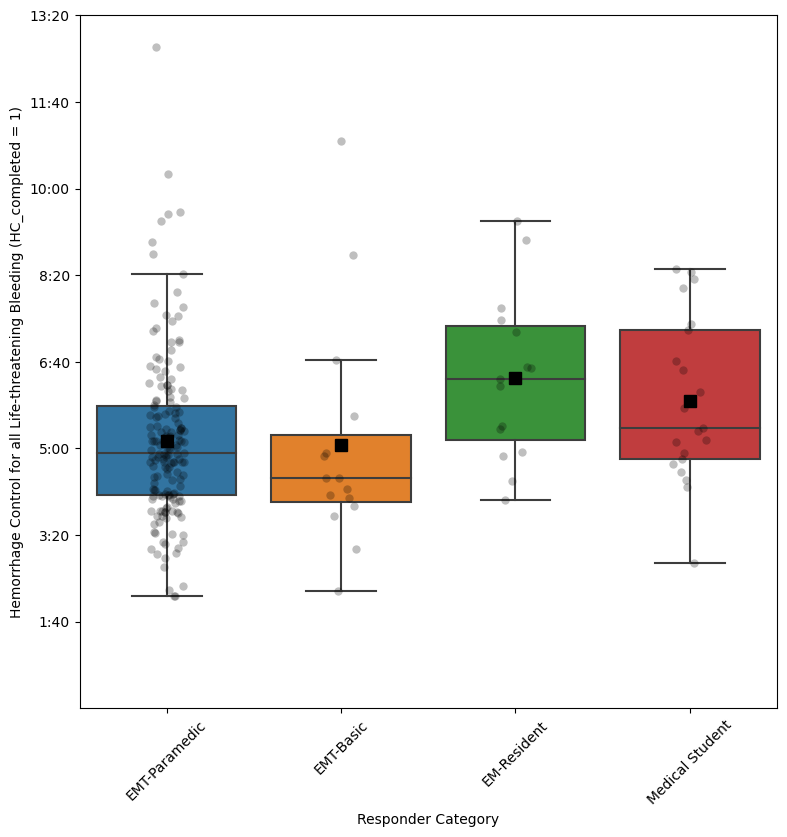

In [10]:

import matplotlib.pyplot as plt

fig, ax = show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn, logs_df=hc_completed_df)